# A survey of TSP heuristics

<center><img src=https://imgs.xkcd.com/comics/travelling_salesman_problem.png width=450></center>

## Preliminaries

### Modelisation

Let $G = (V, \vec{E})$, where $V$ is a set of **vertices** and a set of **arcs**, be a **directed** **weighted** **complete** graph :
- **directed** : every $\vec{e} \in \vec{E}$ is a couple $\vec{e} = (u, v)$, representing an one-way direction from $u \in V$ to $v \in V$.  
- **weighted** : every $\vec{e} = (u, v) \in \vec{E}$ has a weight $d(u, v)$ (the distance from $u$ to $v$).  
- **complete** : $G$ contains all possible arcs from a vertex to another.

> **Travelling Salesman Problem (TSP)** : find a cycle (or : tour) in $G$ visiting all vertices with minimum total weight

In this notebook we will restrict ourself to the **Euclidean TSP**, in which each vertex is a 2D point and we use the euclidean distance between two points.

### Data structures

We will use a numpy array of size $n\times 2$ to store $n$ points. We will test our algorithms on random points :

In [3]:
import numpy as np
from functools import cache

@cache # to compare algorithms on same data
def random_cities(n : int) -> np.array: # generate n points (x, y) with 0 <= x < 1000 and 0 <= y < 400
    return np.random.uniform(0, (1000, 400), size=(n, 2))

random_cities(4)

array([[608.56099553, 120.86949937],
       [206.81814124, 389.95142943],
       [967.45077125,   1.92953291],
       [699.57226816, 398.66612026]])

A cycle will be  a list of points containing the vertices in the order they appear in the cycle. The length of a cycle is the sum of the euclidean distances between each vertex and the next :

In [5]:
def d(p, q):
    return np.sum((p - q)**2, axis=-1)**.5
    
def length_cycle(cycle : list) -> float:
    return d(cycle, np.roll(cycle, 1, axis=0)).sum()

length_cycle(random_cities(4))

2108.4487091602855

An algorithm for TSP will be implemented as a function with a set of points as argument and returning a cycle :

In [85]:
def algo(points : np.array) -> np.array:
    return ... # cycle

### Vizualisation

In [1]:
import matplotlib.pyplot as plt
import time

def plot_cycle(cycle, t):
    cycle = list(cycle)
    # print(cycle)
    plt.figure(figsize=(20, 6))
    X, Y = zip(*(cycle + [cycle[0]]))
    plt.plot(X, Y, 'bo-')
    plt.axis('scaled')
    plt.suptitle(f"Cycle length: {length_cycle(cycle):.2f}\nTime: {t:.2f}s", fontsize=20)

def test_points(algo, points):
    t = time.time()
    cycle = algo(points)
    plot_cycle(cycle, time.time() - t)

def test(algo, n): # test algorithm on n random cities
    test_points(algo, random_cities(n))

We will also take a look at a real graph, containing the 18 most populated cities in France :

In [217]:
import folium # for map vizualization
import pandas as pd

df = pd.read_csv("villes_france.csv");

def test_france(algo, n):
    f = folium.Figure(width=800, height=400)
    m = folium.Map(location=[46.3833, 4.91667], zoom_start=5)
    df_big = df.sort_values(by=['ville_population_2012'])[["ville_nom", "ville_population_2012", "ville_latitude_deg", "ville_longitude_deg"]][-n:]
    for i in range(len(df_big)):
        # print(df.loc[i, "ville_latitude_deg"], df.loc[i, "ville_longitude_deg"])
        city = df_big.iloc[i]
        folium.CircleMarker(
            location=[city["ville_latitude_deg"], city["ville_longitude_deg"]],
            popup=city["ville_nom"] + " (" + str(city["ville_population_2012"]) + ")",
            icon=folium.Icon(color="green"),
            color="#3186cc",
            fill=True,
            radius=10,
        ).add_to(m)

    points = df_big[["ville_latitude_deg", "ville_longitude_deg"]].to_numpy()
    cycle = list(algo(points))
    cycle.append(cycle[0])
    folium.PolyLine(cycle).add_to(m)
    f.add_child(m)
    return f

## Exact algorithms

### Brute force

The most simple solution is to consider all possible cycles and keep the minimum. This amounts to enumerate all permutations of the vertices :

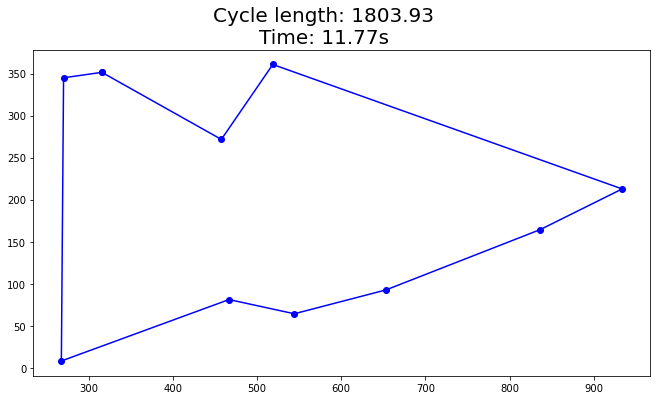

In [199]:
from itertools import permutations

def all_cycles(cities):
    for perm in permutations(cities[1:]):
        yield [cities[0]] + list(perm) # first city is fixed
            
def algo_brute_force(cities):
    cycles = all_cycles(cities)
    return min(cycles, key=length_cycle)

test(algo_brute_force, 10)

The time complexity is O($n!$) (number of permutation of the $n$ cities), which is horrendous and unusable for $n > 10$.

In [218]:
test_france(algo_brute_force, 8)

### Dynamic programming (Held–Karp algorithm)

Assume that $V = \{0, ..., n - 1\}$. Let $S \subseteq \{1, ..., n - 1\}$ and $v \notin S$.  
Let $dp[S, v]$ be the length of a shortest cycle starting at $0$, visiting once every vertex of $S$, and ending in $v$.  
We use the following induction:
$$dp[\emptyset, v] = d(0, v)$$
$$dp[S, v] = \min_{u \in S} dp[S - u, u] + d(u, v)$$

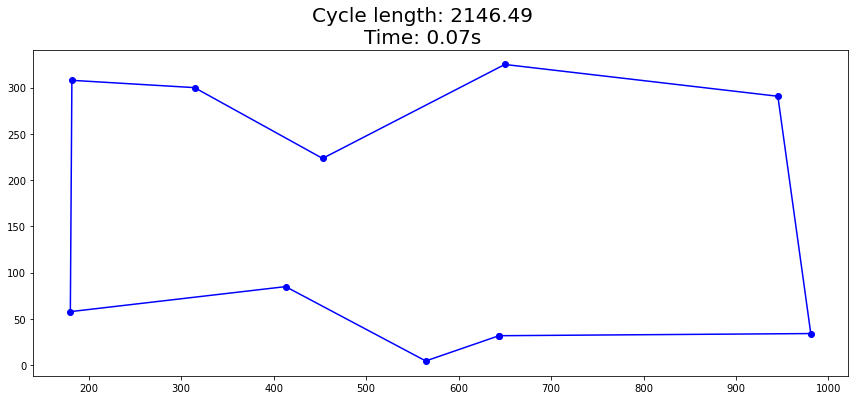

In [250]:
def algo_dp(points):
    def dS(u, v):
        return d(points[u], points[v])

    @cache
    def dp(S, v):
        if len(S) == 0:
            return dS(0, v)
        return min(dp(S - {u}, u) + dS(u, v) for u in S)
    
    def pred(S, v):
        yield points[v]
        if len(S) == 0:
            return points[0]
        u = min((dp(S - {u}, u) + dS(u, v), u) for u in S)[1]
        yield from pred(S - {u}, u)
    
    S = frozenset(range(len(points))) - {0}
    return list(pred(S, 0))
        
test(algo_dp, 10)

In [219]:
test_france(algo_dp, 15)

Unfortunately the complexity is still exponential : O($n2^n$) since we need to compute $dp[S, v]$ for $S \subseteq \{1, ... n - 1\}$ ($2^{n - 1}$ subsets) and $v \in V$ ($n$ vertices).

## Greedy algorithms 

### Nearest neighbors

The nearest neighbors algorithm consists in starting in an arbitrary vertex then iteratively visiting the closest non-visited vertex.

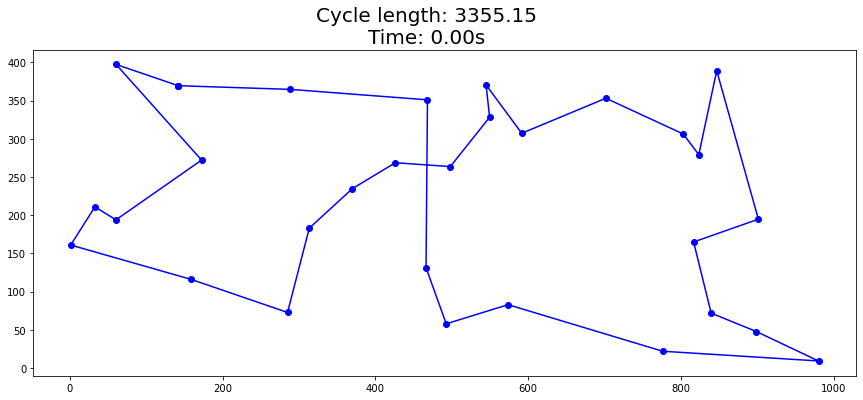

In [281]:
def closest(i, points):
    p = points[i].copy()
    points[i][0] = np.inf
    j = np.argmin(np.sum((points - p)**2, axis=1))
    return j, p
    
def algo_nn(points):
    import copy
    j = 0
    points_copy = copy.deepcopy(points)
    for _ in range(len(points)):
        j, p = closest(j, points_copy)
        yield p
    yield points[0]

test(algo_nn, 20)

### Uncrossing for nearest neighbors

We can observe that there are often "big jumps" in the nearest neighbors solution, like this :

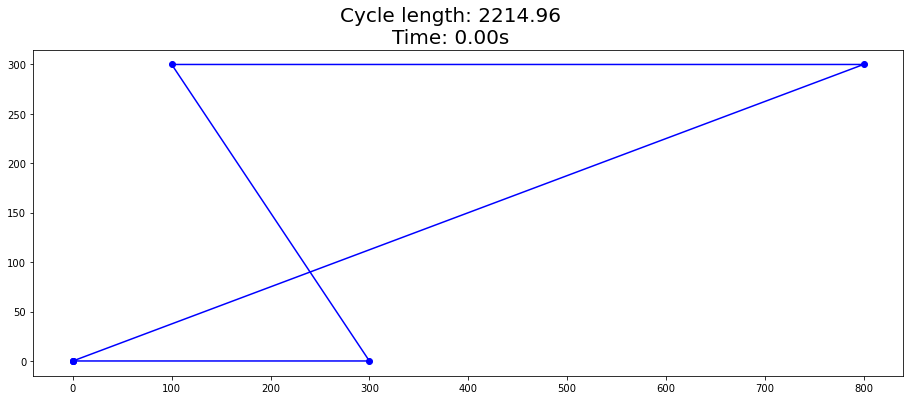

In [284]:
points = np.array([[0, 0], [300, 0], [100, 300], [800, 300]], dtype=float)
test_points(algo_nn, points)

This can be improved by "uncrossing" :

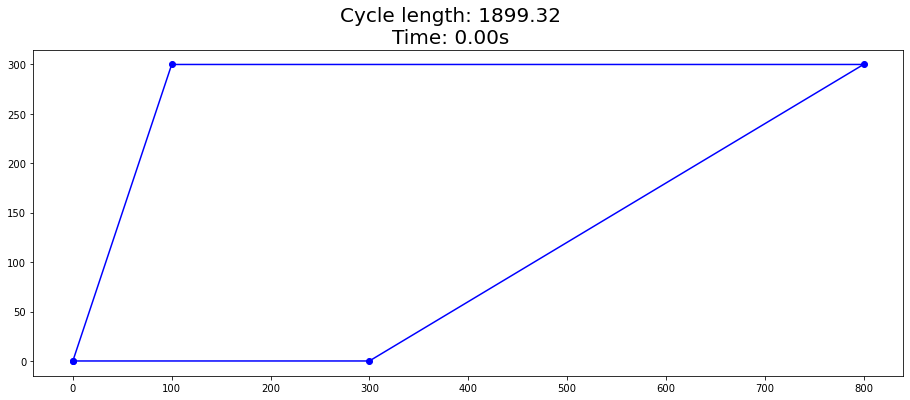

In [285]:
test_points(algo_brute_force, points)

## Genetic algorithm

In [7]:
def crossover(cycle1, cycle2):
    n = len(cycle1)
    cycle = list(cycle1[:n//2])
    for p in cycle2:
        if p not in cycle:
            cycle.append(p)
    return cycle

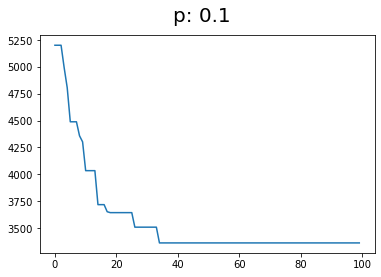

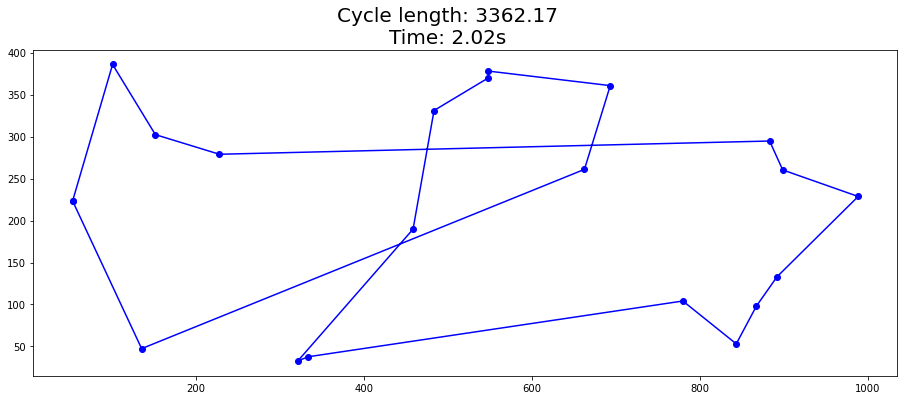

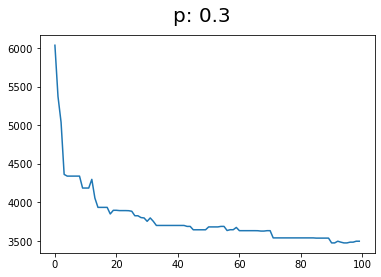

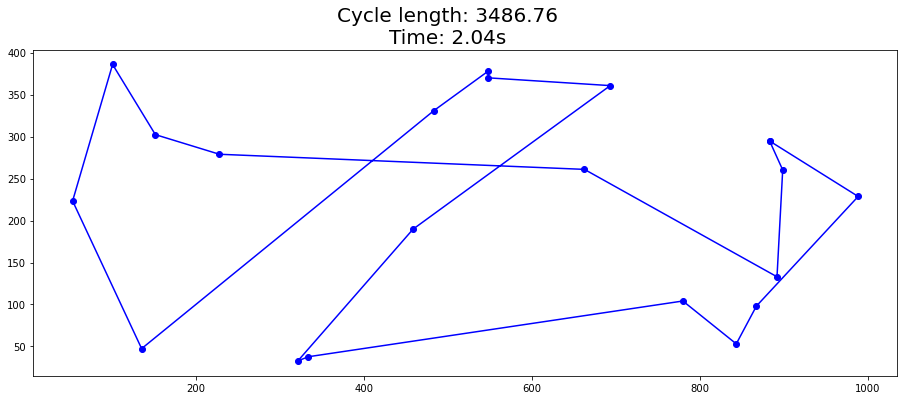

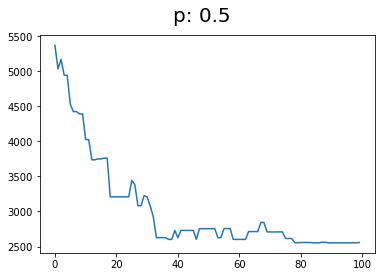

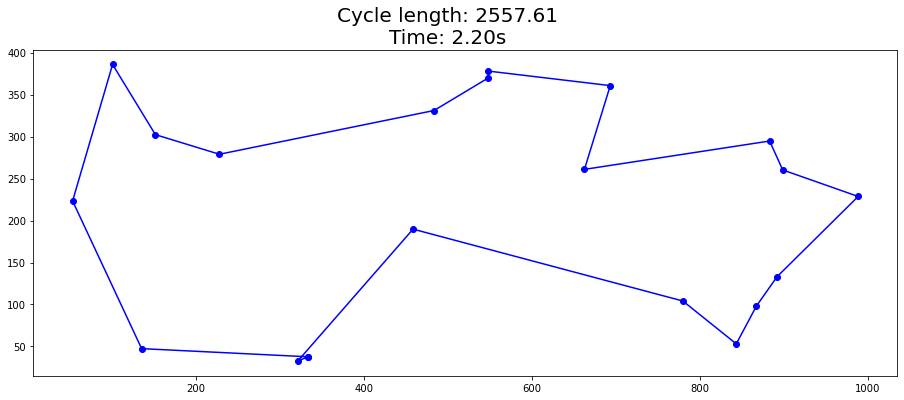

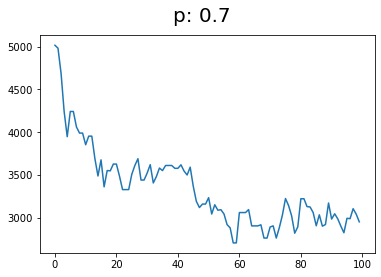

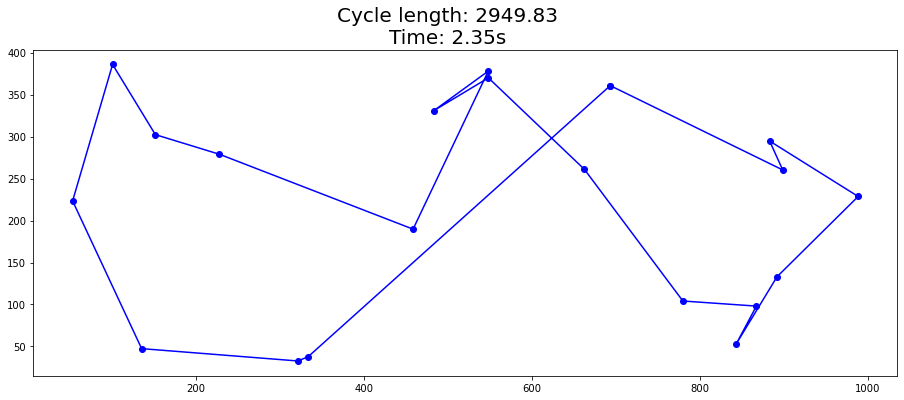

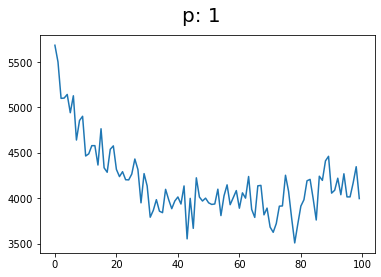

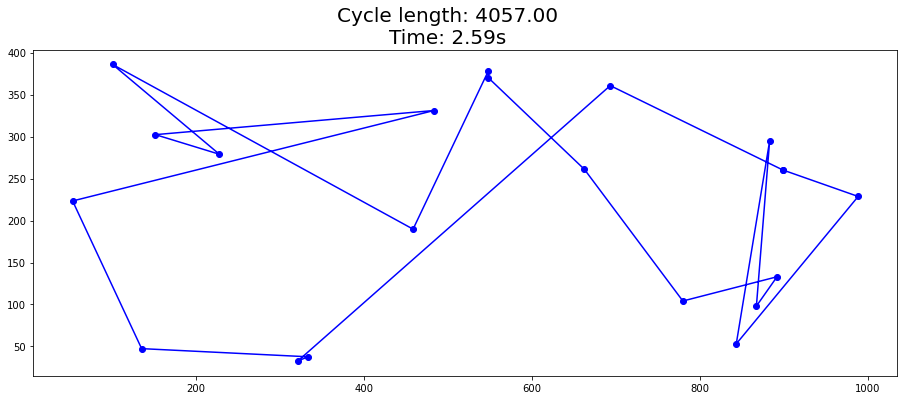

In [27]:
def algo_genetic(points, sz_population=400, iterations=100, mutation_rate=0.1):
    n = len(points)
    Y = []
    population = [list(map(tuple, np.random.permutation(points))) for _ in range(sz_population)]
    for _ in range(iterations):
        population.sort(key=length_cycle)
        Y.append(length_cycle(population[0]))
        for i in range(len(population)):
            if np.random.random() < mutation_rate:
                j, k = np.random.choice(range(n), 2)
                population[i][j], population[i][k] = population[i][k], population[i][j]
        population = population[:len(population)//2]
        population.extend([crossover(population[i-1], population[i]) for i in range(len(population))])
        # if _ % (iterations//5) == 0:
        #     plot_cycle(min(population, key=length_cycle), 0)
    plt.figure()
    plt.plot(range(len(Y)), Y)
    plt.suptitle(f"p: {p}", fontsize=20)
    return min(population, key=length_cycle)

for p in [0.1, 0.3, 0.5, 0.7, 1]:
    test(lambda points: algo_genetic(points, mutation_rate=p), 20)

## Branch and bound